### En primer lugar se creará el conector a SQL

In [13]:
from sqlalchemy import create_engine
import pandas as pd
import os  
import matplotlib.pyplot as plt
engine = create_engine(os.path.join('sqlite:///','data', 'database_challenge.db'))

In [2]:
query ="""
SELECT name 
FROM sqlite_master 
WHERE type='table'
"""
df = pd.read_sql(query, con=engine)
df

,name
0,upl_students
1,upl_courses
2,upl_campuses
3,upl_academicperiods
4,upl_enrollment_statuses
5,reg_enrollments


### Definimos la función de consultas

In [3]:
def consulta(query,conn):
    return pd.read_sql_query(query, con=conn)

In [4]:
conn = create_engine(os.path.join('sqlite:///','data','database_challenge.db'))

##### (a) Generamos la siguiente tabla para ver la cantidad de alumnos matriculados por cada periodo académico. 

In [14]:
query = """
SELECT 
COUNT(DISTINCT id_student) AS cantidad_alumnos, id_academicPeriod as periodo_academico
FROM reg_enrollments
WHERE is_active='1'
GROUP BY id_academicPeriod
"""
consulta(query,conn)
#No consideramos para ninguno de los cálculos los periodos con is_active=0 ya que son registros que no están en uso

,cantidad_alumnos,periodo_academico
0,1026,1
1,1013,3
2,637,5
3,461,6
4,798,8
5,1323,12
6,1537,13
7,1080,15
8,1727,18
9,1132,20


##### Se genera una segunda tabla para conocer cuales son los periodos académicos correspondientes

In [15]:
query = """
SELECT id_code AS codigo,ds_integrationId AS periodo_academico FROM upl_academicperiods
WHERE is_active='1'
"""
consulta(query,conn)

,codigo,periodo_academico
0,1,20151S
1,3,20162S
2,5,20141S
3,6,20142S
4,8,20152S
5,12,20161S
6,13,20171S
7,15,20172S
8,18,20181S
9,20,20182S


##### Con ambas tablas notamos que por cada año tenemos registros activos solo en periodos semestrales, además, la cantidad de estudiantes matriculados por cada semestre de cada año está dado en el siguiente gráfico:

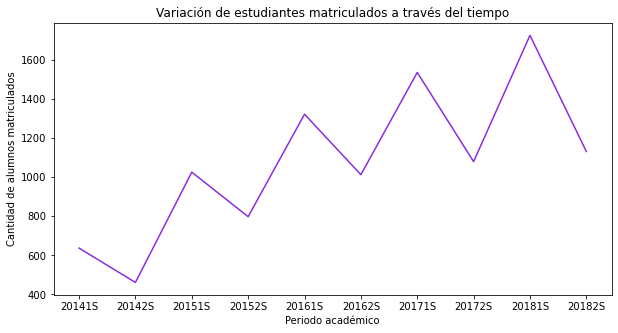

In [19]:
x={'20141S':637,'20142S':461,'20151S':1026,'20152S':798,'20161S':1323,'20162S':1013,'20171S':1537,'20172S':1080,'20181S':1727,'20182S':1132}

plt.figure(figsize=(10, 5))

plt.plot(x.keys(),x.values(),label='linea',color='blueviolet')

plt.title("Variación de estudiantes matriculados a través del tiempo") 
plt.xlabel('Periodo académico') 
plt.ylabel('Cantidad de alumnos matriculados')
plt.show()

##### por lo que podemos ver que en cada año, el primer semestre hay más estudiantes matriculados que el segundo semestre, y que cada año se van matriculando más estudiantes.

##### (b) generamos una tabla que nos muestre cuantos ramos tomó cada alumno en cada periodo de tiempo

In [7]:
query2="""
SELECT 
id_academicPeriod AS periodo_academico, COUNT(id_course) AS cantidad_cursos FROM reg_enrollments
WHERE is_active='1'
GROUP BY id_academicPeriod , id_student
"""
consulta(query2,conn)

,periodo_academico,cantidad_cursos
0,1,4
1,1,4
2,1,4
3,1,4
4,1,4
...,...,...
10729,20,4
10730,20,5
10731,20,5
10732,20,4


##### Luego, por cada periodo de tiempo obtenemos el promedio de ramos inscritos

In [8]:
per=consulta(query2,conn)['periodo_academico'].unique()
prom=0
for p in per:
    df_aux = consulta(query2,conn).loc[lambda x: x['periodo_academico'] == p].cantidad_cursos.mean()
    print('En el periodo académico',p, 'el promedio de ramos inscritos es:', df_aux)

En el periodo académico 1 el promedio de ramos inscritos es: 3.9717348927875245
En el periodo académico 3 el promedio de ramos inscritos es: 4.815399802566634
En el periodo académico 5 el promedio de ramos inscritos es: 3.0
En el periodo académico 6 el promedio de ramos inscritos es: 3.0
En el periodo académico 8 el promedio de ramos inscritos es: 4.0
En el periodo académico 12 el promedio de ramos inscritos es: 4.799697656840514
En el periodo académico 13 el promedio de ramos inscritos es: 4.69811320754717
En el periodo académico 15 el promedio de ramos inscritos es: 4.734259259259259
En el periodo académico 18 el promedio de ramos inscritos es: 4.699478865083961
En el periodo académico 20 el promedio de ramos inscritos es: 4.7871024734982335


##### Utilizando la misma tabla de los periodos de tiempo, tenemos que el promedio de ramos por cada semestre (aproximados a la unidad) serían:

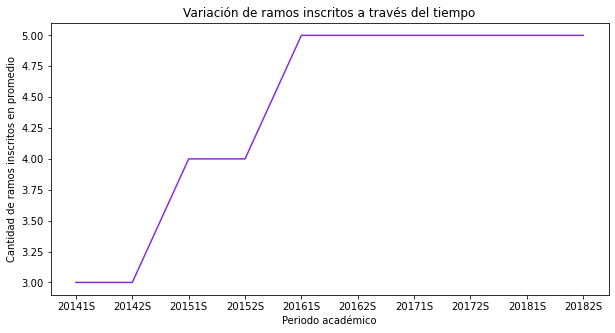

In [20]:
x={'20141S':3,'20142S':3,'20151S':4,'20152S':4,'20161S':5,'20162S':5,'20171S':5,'20172S':5,'20181S':5,'20182S':5}

plt.figure(figsize=(10, 5))

plt.plot(x.keys(),x.values(),label='linea',color='blueviolet')

plt.title("Variación de ramos inscritos a través del tiempo") 
plt.xlabel('Periodo académico') 
plt.ylabel('Cantidad de ramos inscritos en promedio')
plt.show()

##### Y vemos que la cantidad de ramos promedio inscritos por los alumnos fue aumentando en el periodo de 2014-2016 para luego mantenerse en 5 ramos inscritos en promedio.

##### (c) Generamos la tabla para contar cuantos reprobados hay por cada curso y la ordenamos de mayor a menor

In [9]:
query3="""
SELECT id_course AS curso, COUNT(id_status) AS cantidad_reprobados FROM reg_enrollments
WHERE (id_academicPeriod='1') AND (id_status=2) AND (is_active='1')
GROUP BY id_course
ORDER BY COUNT(id_status) DESC

"""
consulta(query3,conn)

,curso,cantidad_reprobados
0,3421,67
1,3416,53
2,3437,20
3,2357,13
4,1250,12
...,...,...
141,1018,1
142,1001,1
143,997,1
144,984,1


##### Así obetenemos los 5 ramos con mayor tasa de reprobación, luego generamos una segunda tabla para revisar cuales son los cursos mencionados

In [10]:
query4="""
SELECT id_code, ds_name FROM upl_courses
WHERE (id_code='3421') OR (id_code='3416') OR (id_code='3437') OR (id_code='2357') OR (id_code='1250')
"""
consulta(query4,conn)

,id_code,ds_name
0,1250,Inglés 1
1,2357,Inglés 1
2,3416,Introducción A La Física Universitaria
3,3421,Introducción A La Matemática Universitaria
4,3437,Química General Básica


##### Por lo que los 5 ramos con mayor tasa de reprobación en el periodo 2015 1S son:
* Introducción A La Matemática Universitaria (3421): 67 reprobados
* Introducción A La Física Universitaria (3416): 53 reprobados
* Química General Básica (3437): 20 reprobados
* Inglés 1 (2357): 13 reprobados
* Inglés 1 (1250): 12 reprobados

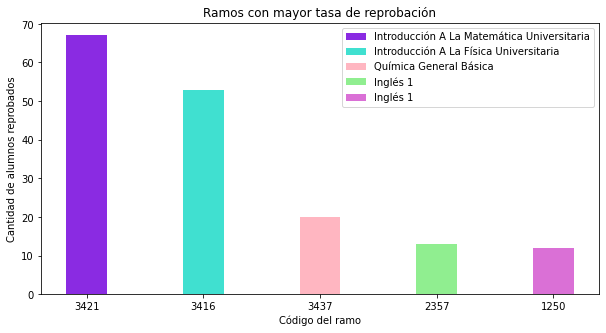

In [34]:
x1={'3421': 67}
x2={'3416': 53}
x3={'3437': 20}
x4={'2357': 13}
x5={'1250': 12}

plt.figure(figsize=(10, 5))

plt.bar(x1.keys(),x1.values(),0.35,color='blueviolet')
plt.bar(x2.keys(),x2.values(),0.35,color='turquoise')
plt.bar(x3.keys(),x3.values(),0.35,color='lightpink')
plt.bar(x4.keys(),x4.values(),0.35,color='lightgreen')
plt.bar(x5.keys(),x5.values(),0.35,color='orchid')

plt.legend(['Introducción A La Matemática Universitaria','Introducción A La Física Universitaria','Química General Básica','Inglés 1','Inglés 1'])
plt.title("Ramos con mayor tasa de reprobación") 
plt.xlabel('Código del ramo') 
plt.ylabel('Cantidad de alumnos reprobados')
plt.show()